<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/EVA4_S5_F5_Image_Aug_LR_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **5.	Use image augmentation and fine-tune LR**
File Name : EVA4_S5_Image Aug_LR Change.ipynb
#### **Target**
*	Use image augmentation to give more variety of images while training the model
*	Fine-tune LR using stepLR
#### **Results:**
*	Parameters: 9,680
*	Best Training Accuracy: 99.23
*	Best Test Accuracy: 99.40
#### **Analysis:**
*	RandomHorizontalFlip reduces accuracy and hence shouldn’t be used.
*	With random rotation & color jitter able to get steady accuracy improvement.
*	Used steplr for step-size of 6 with a multiplication factor of 0.1.
*	Test accuracy reached 99.40 but just once. Model needs further improvement to consistently touch >= 99.40%.


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations



In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7,7),fill=(1,)),
                                      #  transforms.RandomHorizontalFlip(),
                                      # transforms.RandomErasing(p=0.2,scale=(0.05,0.15)), 
                                       transforms.ToTensor(),                                       
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 28x28x1 , out = 26x26x16, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 26x26x16 , out = 24x24x16, RF = 5
 
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # in = 24x24x16 , out = 12x12x16, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 12x12x16 , out = 10x10x16, RF = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 10x10x16 , out = 8x8x16, RF = 14

        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 8x8x16 , out = 6x6x16, RF = 18
        self.Gap1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1,1))
        ) # in = 6x6x16 , out = 1x1x16, RF = 28	
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16, out_features=10, bias=False)
        ) # in = 1x1x16 , out = 1x1x10, RF = 28

    def forward(self, x):
        x = self.convblock2(self.convblock1(x))
        x = self.pool1(x)
        x = self.convblock4(self.convblock3(x))
        x = self.Gap1(self.convblock5(x))
        x = x.view(-1, 16)
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_acc_epoch = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    # in view() method the shape of the desired output tensor is to be passed in as the parameter,
    # whereas in view_as() a tensor whose shape is to be mimicked it passed.
    # tensor.view_as(other) is equivalent to tensor.view(other.size())
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Running the Model

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.01)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09404029697179794 Batch_id=468 Train Accuracy=91.55: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Test Accuracy: 9846/10000 (98.46%)

EPOCH: 1


Loss=0.020819127559661865 Batch_id=468 Train Accuracy=98.07: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Test Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.05400046706199646 Batch_id=468 Train Accuracy=98.47: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Test Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.05227882042527199 Batch_id=468 Train Accuracy=98.63: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.005299533251672983 Batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.02040441893041134 Batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:21<00:00, 27.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.013382519595324993 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Test Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.029380643740296364 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:21<00:00, 27.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.07930227369070053 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.028384825214743614 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.04192827269434929 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.053545668721199036 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 26.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.024788282811641693 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:21<00:00, 27.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.005102162715047598 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.0026744604110717773 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]



Test set: Average loss: 0.0221, Test Accuracy: 9929/10000 (99.29%)



In [0]:
print('\nMaxium test accuracy: {:.2f}, Achieved in epoch: {}, Max Train accuracy : {:.2f}, Achieved in epoch : {}\n'.format(
        max(test_acc),  np.argmax(test_acc) , max(train_acc_epoch), np.argmax(train_acc_epoch))   )


Maxium test accuracy: 99.40, Achieved in epoch: 12, Max Train accuracy : 99.23, Achieved in epoch : 13



Text(0.5, 1.0, 'Test Accuracy')

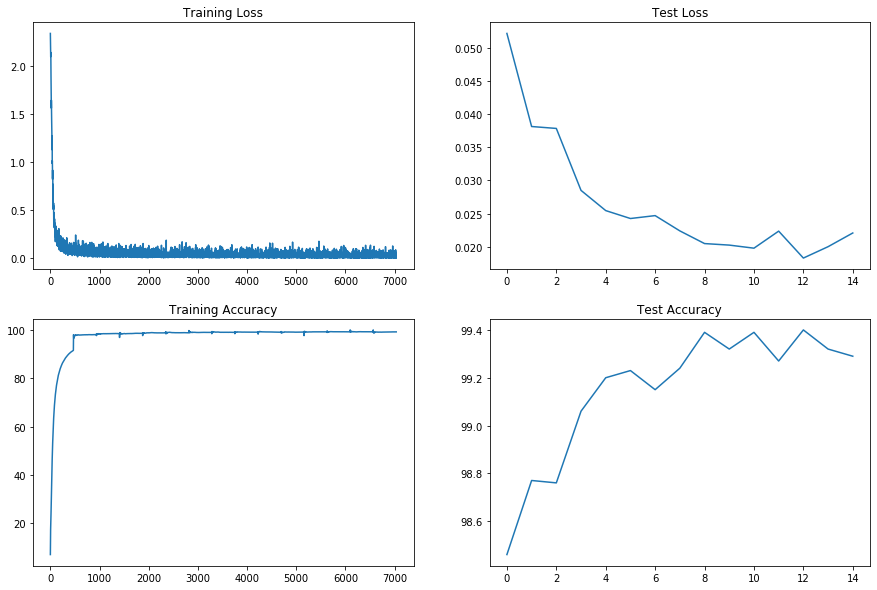

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")